<a href="https://colab.research.google.com/gist/22961-Deep-learning/06cc7452c5c6f012e2977d95c153ca78/22961_5_3_5_4_conv_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

train_data_transformed = torchvision.datasets.FashionMNIST(
    root="/22961", train=True, download=True,
    transform=torchvision.transforms.ToTensor())

train_dataloader = DataLoader(
    train_data_transformed, batch_size=1)
img, _ = next(iter(train_dataloader))

In [2]:
class ConvLayer_1(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.kern = nn.Parameter(torch.rand(kernel_size))
        self.p , self.q = kernel_size
    def forward(self, X):
      output = torch.empty(X.size(0),
                           X.size(1)-self.p+1,
                           X.size(2)-self.q+1)
      for i in range(output.size(1)):
        for j in range(output.size(2)):
          sub_img=X[:,i:(i+self.p),j:(j+self.q)]
          output[:,i,j]=(sub_img*self.kern).sum(dim=(1,2))
      return output

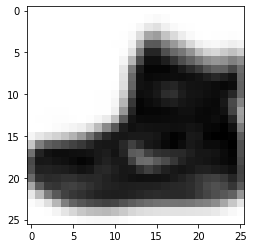

In [3]:
B=ConvLayer_1((3,3))
B.kern.requires_grad=False
B.kern[:]=torch.tensor([[1/16,1/8,1/16],
                     [1/8,1/4,1/8],
                     [1/16,1/8,1/16]])
img2=B(img.reshape(1,28,28))
plt.imshow(img2.detach().squeeze(),cmap='Greys');

#Finding a Kernel via SGD

In [4]:
edge_detector=ConvLayer_1((3,3))
edge_detector.kern.requires_grad=False
edge_detector.kern[:]=torch.tensor([[-1.,-1,-1],
                                    [0,0,0],
                                    [1,1,1]])

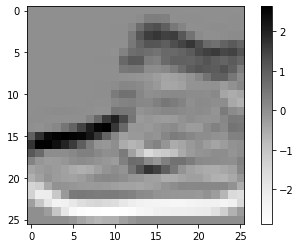

In [5]:
img2=edge_detector(img.reshape(1,28,28))
plt.imshow(img2.detach().squeeze(),cmap='Greys');
plt.colorbar();

In [6]:
train_dataloader = DataLoader(
    train_data_transformed, batch_size=512)

my_conv=ConvLayer_1((3,3));
optimizer = torch.optim.SGD(my_conv.parameters(), lr=0.1)

def iterate_batch(imgs):
  optimizer.zero_grad()
  my_transformed_imgs = my_conv(imgs)
  target_imgs = edge_detector(imgs)
  loss = ((my_transformed_imgs-target_imgs)**2).mean()
  loss.backward()
  optimizer.step()
  return loss



In [7]:
from tqdm import tqdm
batches=len(train_dataloader)

batch_loss=torch.zeros(batches)
for idx, (imgs, _) in tqdm(enumerate(train_dataloader),total=batches):
  imgs=imgs.squeeze()
  batch_loss[idx] = iterate_batch(imgs)

100%|██████████| 118/118 [00:32<00:00,  3.61it/s]


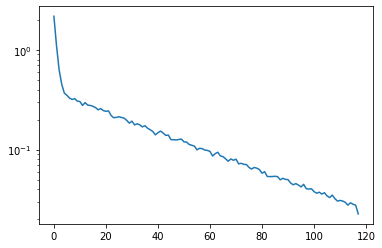

In [8]:
plt.semilogy(batch_loss.detach());

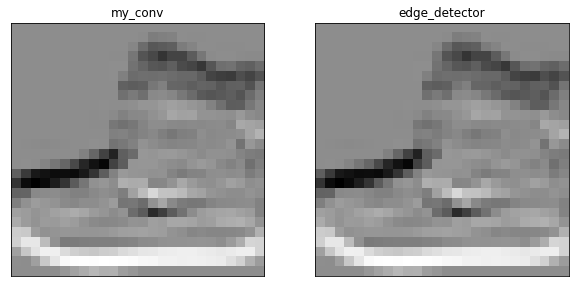

In [9]:
imgs, _ = next(iter(train_dataloader))
imgs=imgs.squeeze()
my_transformed_imgs = my_conv(imgs)
target_imgs = edge_detector(imgs)

fig,axes = plt.subplots(1,2)
fig.set_figheight(6)
fig.set_figwidth(10)
axes[0].imshow(my_transformed_imgs[0,...].detach(),cmap='Greys')
axes[0].set_title("my_conv")
axes[0].axes.get_xaxis().set_visible(False)
axes[0].axes.get_yaxis().set_visible(False)


axes[1].imshow(my_transformed_imgs[0,...].detach(),cmap='Greys')
axes[1].set_title("edge_detector")
axes[1].axes.get_xaxis().set_visible(False)
axes[1].axes.get_yaxis().set_visible(False)

In [10]:
print(my_conv.kern)

Parameter containing:
tensor([[-0.9739, -0.5325, -0.9386],
        [ 0.3821, -0.1419,  0.1774],
        [ 0.5991,  0.6170,  0.8060]], requires_grad=True)


#5.4 Conv Layer Details

Multiple Output Channels

In [11]:
class ConvLayer_2(nn.Module):
    def __init__(self,out_channels=1, kernel_size=(1,1)):
        super().__init__()
        self.kern = nn.Parameter(
            torch.rand((out_channels,*kernel_size)))
        self.p , self.q = kernel_size
        self.out_channels=out_channels
    def forward(self, X):
      output = torch.empty(X.size(0),
                           self.out_channels,
                           X.size(1)-self.p+1,
                           X.size(2)-self.q+1)
      for i in range(output.size(2)):
        for j in range(output.size(3)):
          sub_img=X[:,i:(i+self.p),j:(j+self.q)]
          sub_img=sub_img.unsqueeze(1)
          output[:,:,i,j]=(sub_img*self.kern).sum(dim=(2,3))
      return output

In [12]:
edge_detector2=ConvLayer_2(2,(3,3))
filters=torch.tensor(
    [[[-1.,-1,-1],
      [0,0,0],
      [1,1,1]],
     
     [[-1,0,1],
      [-1,0,1],
      [-1,0,1]]])
print(filters.size())
edge_detector2.kern.requires_grad=False
edge_detector2.kern[:]=filters
print(imgs.size())
edges_detected=edge_detector2(imgs)
print(edges_detected.size())

torch.Size([2, 3, 3])
torch.Size([512, 28, 28])
torch.Size([512, 2, 26, 26])


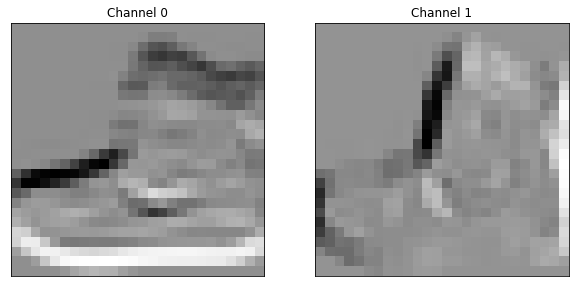

In [13]:

fig,axes = plt.subplots(1,2)
fig.set_figheight(6)
fig.set_figwidth(10)

axes[0].imshow(edges_detected[0,0,...].detach(),cmap='Greys')
axes[0].set_title("Channel 0")
axes[0].axes.get_xaxis().set_visible(False)
axes[0].axes.get_yaxis().set_visible(False)


axes[1].imshow(edges_detected[0,1,...].detach(),cmap='Greys')
axes[1].set_title("Channel 1")
axes[1].axes.get_xaxis().set_visible(False)
axes[1].axes.get_yaxis().set_visible(False)

Multiple input channels

In [14]:
class ConvLayer_3(nn.Module):
    def __init__(self,in_channels=1, kernel_size=(1,1)):
        super().__init__()
        self.kern = nn.Parameter(
            torch.rand((in_channels,*kernel_size)))
        self.p , self.q  = kernel_size
        self.in_channels = in_channels
    def forward(self, X):
      output = torch.empty(X.size(0),
                           X.size(2)-self.p+1,
                           X.size(3)-self.q+1)
      for i in range(output.size(1)):
        for j in range(output.size(2)):
          sub_img=X[:,:,i:(i+self.p),j:(j+self.q)]
          output[:,i,j]=(sub_img*self.kern).sum(dim=(1,2,3))
      return output

torch.Size([2, 1, 1])
torch.Size([512, 26, 26])


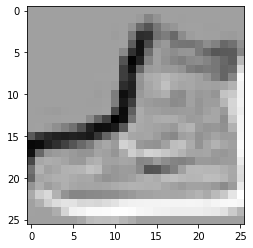

In [15]:
aggregate=ConvLayer_3(2,(1,1))
aggregate.kern = nn.Parameter(torch.tensor(0.5).expand(2,1,1))
edges_aggregated=aggregate(edges_detected)

print(aggregate.kern.size())
print(edges_aggregated.size())
plt.imshow(edges_aggregated[0,...].detach(),cmap='Greys');